In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import librosa
import librosa.display

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [2]:
# Data information
DATA_ROOT = 'data/'
DATA_SPLIT = 0.8
N_FEATURES = 32
N_CLASSES = 2

# Training settings
N_EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [3]:
def extract_features(filepath, n_features=40):
    signal, sr = librosa.load(filepath)
    return librosa.feature.mfcc(signal, sr, n_mfcc=n_features).T

In [4]:
def load_dataset(data_root, n_classes, n_features=40):
    data = []
    
    for i in range(n_classes):
        class_files = os.listdir(data_root + str(i))
        
        for filename in class_files:
            filepath = data_root + str(i) + '/' + filename

            x = extract_features(filepath, n_features=n_features)
            y = np.array([i]) # Force correct input size

            data.append((x, y, filename))

    np.random.shuffle(data)
    return data

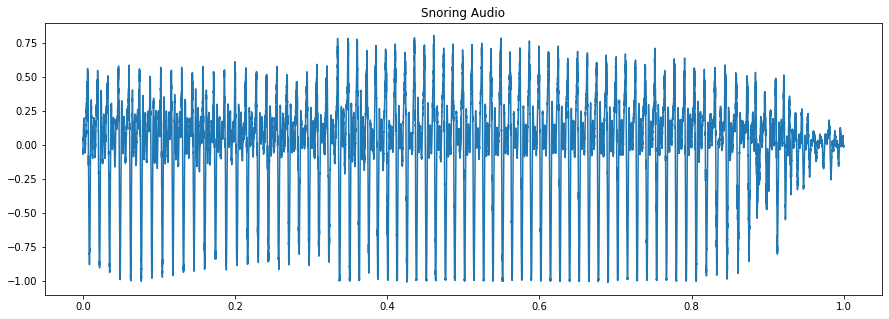

In [5]:
plt.figure(figsize=(15, 5))

audio_file = 'data/1/1_371.wav'
signal, sr = librosa.load(audio_file)
plt.plot(np.arange(0, len(signal)) / sr, signal)
plt.title('Snoring Audio')
plt.show()

ipd.Audio(audio_file)

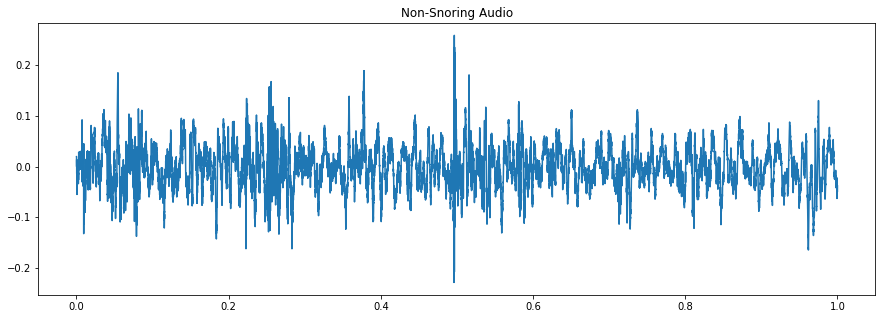

In [6]:
plt.figure(figsize=(15, 5))

audio_file = 'data/0/0_57.wav'
signal, sr = librosa.load(audio_file)
plt.plot(np.arange(0, len(signal)) / sr, signal)
plt.title('Non-Snoring Audio')
plt.show()

ipd.Audio(audio_file)

In [7]:
data = load_dataset(DATA_ROOT, N_CLASSES, n_features=N_FEATURES)

# Split train and test data and create dataloaders
split_index = int(len(data) * DATA_SPLIT)
train_data = data[:split_index]
test_data = data[split_index:]

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class Classifier(nn.Module):
    def __init__(self, n_features=40):
        super(Classifier, self).__init__()
        
        self.lin1 = nn.Linear(n_features, 150)
        self.lin2 = nn.Linear(150, 150)
        self.lstm = nn.LSTM(150, 75, bidirectional=True, batch_first=True)
        self.lin3 = nn.Linear(150, 1)
        self.drop = nn.Dropout(0.2)
    
    def forward(self, x, device='cpu'):
        b_len, s_len, _ = x.shape
        
        # Initialize hidden and cell state
        hidden = (torch.zeros(2, b_len, 75).to(device),
                  torch.zeros(2, b_len, 75).to(device))
        
        # Create mind vector and run trough LSTM
        y = F.relu(self.lin1(x))
        y = self.drop(y)
        y = F.relu(self.lin2(y))
        y, _ = self.lstm(y, hidden)
        
        # Get last prediction from LSTM
        y = y[:, -1, :]
        
        # Classify
        y = self.drop(y)
        y = torch.sigmoid(self.lin3(y))
        return y

In [9]:
def accuracy(model, test_data):
    n_cor, n_tot = 0, 0 # Track total and correct predictions
    with torch.no_grad():
        for x, y, _ in test_data:
            y_hat = torch.round(model(x))
            
            n_tot += y.size(0)
            n_cor += (y_hat == y).sum().item()
    
    return round(100 * (n_cor / n_tot), 2)

In [10]:
def confusion(model, test_data):
    result = torch.tensor([[0, 0], [0, 0]]) # Track TP, FP, FN, TN
    with torch.no_grad():
        for x, y, _ in test_data:
            y_hat = torch.round(model(x)).long()
            result[0, 0] += sum(y_hat * y).item()
            result[0, 1] += sum(y_hat * (1 - y)).item()
            result[1, 0] += sum((1 - y_hat) * y).item()
            result[1, 1] += sum((1 - y_hat) * (1 - y)).item()
    return result

In [51]:
def get_incorrect(model, test_data):
    result = []
    with torch.no_grad():
        for x, y, file in test_data:
            y_hat = torch.round(model(x)).long()
            file = np.array(file)
            incorrect = file[(y_hat != y).view(len(y))]
            result += list(incorrect)
    return result

In [12]:
model = Classifier(n_features=N_FEATURES)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
for epoch in range(1, N_EPOCHS + 1):
    for x, y, _ in train_loader:
        optimizer.zero_grad()
        
        y = y.float()
        y_hat = model(x)
        
        # Calculate loss and gradients w.r.t. loss
        loss = F.binary_cross_entropy(y_hat, y)
        loss.backward()
        
        # Step on gradients
        optimizer.step()
        
    train_acc, test_acc = accuracy(model, train_loader), accuracy(model, test_loader)
    print(f'\rEpoch [{epoch}/{N_EPOCHS}]\t | Train Accuracy: {train_acc}%\t | Test Accuracy: {test_acc}%\t', end="")

Epoch [100/100]	 | Train Accuracy: 100.0%	 | Test Accuracy: 98.5%	

In [14]:
model.eval()
snore_test = extract_features('data/1/1_371.wav', n_features=N_FEATURES)
prediction = model(torch.tensor([snore_test]))
prediction = round(prediction.item() * 100, 2)

if prediction > 50:
    print(f'Your recording was a snore. ({prediction}% confident)')
else:
    print(f'Your recording was not a snore. ({100 - prediction}% confident)')

Your recording was a snore. (100.0% confident)


In [15]:
torch.save(model.state_dict(), 'model.pt')

In [54]:
train_confusion = confusion(model, train_loader)
test_confusion = confusion(model, test_loader)
test_incorrect = get_incorrect(model, test_loader)

print('Train Confusion Matrix:')
print(train_confusion)

print('Test Confusion Matrix:')
print(test_confusion)

print('Test Incorrect Files:')
print(test_incorrect)

Train Confusion Matrix:
tensor([[396,   0],
        [  0, 404]])
Test Confusion Matrix:
tensor([[102,   1],
        [  2,  95]])
Test Incorrect Files:
['1_283.wav', '0_175.wav', '1_284.wav']


In [65]:
audio_file = 'data/1/1_284.wav'
ipd.Audio(audio_file)